In [2]:
pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------- ----------------- 7.3/13.3 MB 37.6 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 34.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/791.2 kB ? eta -:--:--
   --------------------------------------- 791.2/791.2 kB 33.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from prophet import Prophet
import numpy as np

# 파일 경로 설정
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"

# 데이터 로드
df = pd.read_csv(file_path)

# 필요한 칼럼 선택
df = df[['기준_년분기_코드', '상권_코드_명', '월요일_매출_금액', '화요일_매출_금액', 
          '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액']]

# 기준_년분기_코드를 날짜로 변환 (각 분기의 첫 번째 날)
def convert_quarter_to_date(quarter_code):
    year = int(str(quarter_code)[:4])
    quarter = int(str(quarter_code)[4:])
    month = {1: '01', 2: '04', 3: '07', 4: '10'}[quarter]
    return f"{year}-{month}-01"

df['날짜'] = df['기준_년분기_코드'].apply(convert_quarter_to_date)
df['날짜'] = pd.to_datetime(df['날짜'])

# 요일 매출 데이터 가공
daily_sales_list = []
for _, row in df.iterrows():
    base_date = row['날짜']
    sales_values = [row['월요일_매출_금액'], row['화요일_매출_금액'], row['수요일_매출_금액'],
                     row['목요일_매출_금액'], row['금요일_매출_금액'], row['토요일_매출_금액'], row['일요일_매출_금액']]
    
    # 분기 기준 데이터를 주차 단위로 반복하며 매일 데이터를 생성
    for week_offset in range(13):  # 분기는 13주
        week_start_date = base_date + pd.Timedelta(weeks=week_offset)
        for day_offset, sales_value in enumerate(sales_values):
            daily_date = week_start_date + pd.Timedelta(days=day_offset)
            daily_sales_list.append({
                '날짜': daily_date,
                '요일': daily_date.strftime('%A'),
                '상권명': row['상권_코드_명'],
                '매출': sales_value / 13  # 주차 단위 매출 평균으로 나눔
            })

# 데이터프레임 변환
daily_sales_df = pd.DataFrame(daily_sales_list)

# 결과 저장
output_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\일단위_매출_추정치.csv"
daily_sales_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print("일 단위 매출 데이터 추정 작업이 완료되었습니다.")

일 단위 매출 데이터 추정 작업이 완료되었습니다.


데이터 검증코드

In [1]:
import pandas as pd

# 데이터 불러오기
preprocessed_df = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\일단위_매출_추정치.csv")  # 전처리 데이터
original_df = pd.read_csv(r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv")  # 원본 데이터

# 날짜 컬럼을 datetime으로 변환
preprocessed_df['날짜'] = pd.to_datetime(preprocessed_df['날짜'])

# 날짜를 기준으로 '기준_년분기_코드' 생성 (YYYYQ 형식)
preprocessed_df['기준_년분기_코드'] = preprocessed_df['날짜'].dt.year.astype(str) + ((preprocessed_df['날짜'].dt.month - 1) // 3 + 1).astype(str)

# 1. 연분기별 매출 총합 비교
# 전처리 데이터에서 연분기별, 상권별 매출 합산
preprocessed_quarter_sales = preprocessed_df.groupby(['기준_년분기_코드', '상권명'])['매출'].sum().reset_index()

# 원본 데이터에서 당월 매출 금액 (연분기별 매출) 선택
original_quarter_sales = original_df[['기준_년분기_코드', '상권_코드_명', '당월_매출_금액']].copy()

# 컬럼명 통일 (상권명 기준)
original_quarter_sales.rename(columns={'상권_코드_명': '상권명', '당월_매출_금액': '원본_매출'}, inplace=True)

# 데이터 병합 후 차이 확인
merged_sales = preprocessed_quarter_sales.merge(original_quarter_sales, on=['기준_년분기_코드', '상권명'], how='left')
merged_sales['매출차이'] = merged_sales['매출'] - merged_sales['원본_매출']

# 매출 차이가 0이 아닌 데이터 확인
sales_mismatch = merged_sales[merged_sales['매출차이'] != 0]

# 2. 요일별 매출 총합 비교
# 전처리 데이터에서 연분기별, 상권별, 요일별 매출 합산
preprocessed_weekly_sales = preprocessed_df.groupby(['기준_년분기_코드', '상권명', '요일'])['매출'].sum().reset_index()

# 원본 데이터에서 요일별 매출 컬럼 추출 및 변환
original_weekly_sales = original_df.melt(id_vars=['기준_년분기_코드', '상권_코드_명'], 
                                         value_vars=['월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액',
                                                     '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액'],
                                         var_name='요일', value_name='원본_요일별_매출')

# 요일 컬럼 변환
original_weekly_sales['요일'] = original_weekly_sales['요일'].str.replace('_매출_금액', '').str.replace('월요일', '월').replace('화요일', '화').replace('수요일', '수')\
    .replace('목요일', '목').replace('금요일', '금').replace('토요일', '토').replace('일요일', '일')

# 컬럼명 통일 (상권명 기준)
original_weekly_sales.rename(columns={'상권_코드_명': '상권명'}, inplace=True)

# 데이터 병합 후 차이 확인
merged_weekly_sales = preprocessed_weekly_sales.merge(original_weekly_sales, on=['기준_년분기_코드', '상권명', '요일'], how='left')
merged_weekly_sales['요일별_매출차이'] = merged_weekly_sales['매출'] - merged_weekly_sales['원본_요일별_매출']

# 요일별 매출 차이가 0이 아닌 데이터 확인
weekly_sales_mismatch = merged_weekly_sales[merged_weekly_sales['요일별_매출차이'] != 0]

# 결과 출력
print("연분기별 매출 차이가 있는 데이터:")
print(sales_mismatch)

print("\n요일별 매출 차이가 있는 데이터:")
print(weekly_sales_mismatch)

ValueError: You are trying to merge on object and int64 columns for key '기준_년분기_코드'. If you wish to proceed you should use pd.concat

In [6]:
import pandas as pd

# 파일 경로 설정
original_file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"
preprocessed_file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\일단위_매출_추정치.csv"

# 데이터 불러오기
original_df = pd.read_csv(original_file_path)
preprocessed_df = pd.read_csv(preprocessed_file_path)

# 날짜 컬럼을 datetime 형식으로 변환
preprocessed_df["날짜"] = pd.to_datetime(preprocessed_df["날짜"])

# 전처리 데이터에서 기준_년분기_코드 생성
def get_quarter_code(date):
    year = date.year
    quarter = (date.month - 1) // 3 + 1
    return f"{year}{quarter}"  # 문자열(str)로 변환

preprocessed_df["기준_년분기_코드"] = preprocessed_df["날짜"].apply(get_quarter_code)

# 📌 1. 전처리된 데이터의 분기별 매출 총합 계산
quarter_sales = preprocessed_df.groupby(["기준_년분기_코드", "상권명"])["매출"].sum().reset_index()

# 📌 2. 원본 데이터에서 분기별 매출을 집계
original_df["당월_매출_금액"] = original_df[["월요일_매출_금액", "화요일_매출_금액", "수요일_매출_금액",
                                          "목요일_매출_금액", "금요일_매출_금액", "토요일_매출_금액", "일요일_매출_금액"]].sum(axis=1)

original_quarter_sales = original_df.groupby(["기준_년분기_코드", "상권_코드_명"])["당월_매출_금액"].sum().reset_index()
original_quarter_sales.rename(columns={"상권_코드_명": "상권명", "당월_매출_금액": "원본_매출"}, inplace=True)

# 📌 🔥 데이터 타입 맞추기 (중요!!)
quarter_sales["기준_년분기_코드"] = quarter_sales["기준_년분기_코드"].astype(str)
original_quarter_sales["기준_년분기_코드"] = original_quarter_sales["기준_년분기_코드"].astype(str)

# 📌 3. 데이터 병합 후 차이 확인
merged_sales = quarter_sales.merge(original_quarter_sales, on=["기준_년분기_코드", "상권명"], how="left")
merged_sales["매출차이"] = merged_sales["매출"] - merged_sales["원본_매출"]

# 📌 4. 차이가 있는 데이터 출력
diff_sales = merged_sales[merged_sales["매출차이"].abs() > 1e-3]
if diff_sales.empty:
    print("✅ 분기별 매출 총합이 원본 데이터와 일치합니다.")
else:
    print("⚠️ 분기별 매출 총합이 원본 데이터와 다릅니다.")
    print(diff_sales)

⚠️ 분기별 매출 총합이 원본 데이터와 다릅니다.
      기준_년분기_코드            상권명            매출         원본_매출          매출차이
0         20191   4.19민주묘지역 2번  2.682584e+08  2.712070e+08 -2.948548e+06
1         20191           63빌딩  1.974116e+08  1.993332e+08 -1.921632e+06
2         20191  DMC(디지털미디어시티)  3.041191e+09  3.050783e+09 -9.592076e+06
3         20191      GS강동자이아파트  5.903896e+08  5.969977e+08 -6.608188e+06
4         20191            G타워  2.215648e+08  2.236545e+08 -2.089705e+06
...         ...            ...           ...           ...           ...
27006     20232        효창동주민센터  2.378038e+08  2.363720e+08  1.431883e+06
27007     20232        후암동주민센터  7.537991e+08  7.495219e+08  4.277202e+06
27008     20232           후암시장  7.540955e+08  7.495562e+08  4.539292e+06
27009     20232        휘문고교사거리  9.547698e+09  9.546515e+09  1.182764e+06
27010     20232           흑리단길  1.141724e+09  1.137050e+09  4.674159e+06

[11715 rows x 5 columns]


In [7]:
import numpy as np

# 📌 매출 대비 오차 비율(%) 계산
merged_sales["오차비율(%)"] = (merged_sales["매출차이"] / merged_sales["원본_매출"]) * 100

# 📊 전체 평균 오차 비율
mean_error = merged_sales["오차비율(%)"].mean()
median_error = merged_sales["오차비율(%)"].median()
max_error = merged_sales["오차비율(%)"].max()
min_error = merged_sales["오차비율(%)"].min()
std_dev = merged_sales["오차비율(%)"].std()

# ⚠️ 오차가 큰 상권 확인 (절대값 기준 5% 이상)
large_errors = merged_sales[merged_sales["오차비율(%)"].abs() > 5]

print(f"📊 평균 오차 비율: {mean_error:.4f}%")
print(f"📊 중앙값 오차 비율: {median_error:.4f}%")
print(f"📈 최대 오차 비율: {max_error:.4f}%")
print(f"📉 최소 오차 비율: {min_error:.4f}%")
print(f"📊 표준편차: {std_dev:.4f}%")
print(f"⚠️ 오차가 5% 이상인 데이터 개수: {len(large_errors)}개 / {len(merged_sales)}개")

# 📌 오차가 큰 상권 상위 10개 출력
print(large_errors.head(10))

📊 평균 오차 비율: -0.0067%
📊 중앙값 오차 비율: 0.0000%
📈 최대 오차 비율: 35.2485%
📉 최소 오차 비율: -7.6923%
📊 표준편차: 0.5703%
⚠️ 오차가 5% 이상인 데이터 개수: 10개 / 33021개
      기준_년분기_코드          상권명            매출         원본_매출          매출차이  \
1292      20191     중곡1동주민센터  1.675343e+05  1.814955e+05 -1.396119e+04   
1648      20192        광진경찰서  3.737195e+06  2.763206e+06  9.739897e+05   
2792      20192     중곡1동주민센터  2.045314e+05  1.905702e+05  1.396119e+04   
2933      20192       헌인가구단지  6.756818e+05  6.281701e+05  4.751168e+04   
2938      20192        홍남교남측  2.152892e+07  2.037803e+07  1.150888e+06   
20209     20222        새석관시장  1.429342e+06  1.317718e+06  1.116237e+05   
25574     20232      개미어린이공원  7.173754e+06  5.593344e+06  1.580410e+06   
26279     20232        서초소방서  1.914530e+06  1.777778e+06  1.367521e+05   
26442     20232       신림역 1번  1.068046e+06  8.136818e+05  2.543644e+05   
26678     20232  우장산롯데캐슬아파트앞  9.617592e+07  8.788174e+07  8.294184e+06   

         오차비율(%)  
1292   -7.692308  
1648   35.24

In [10]:
import pandas as pd

# 파일 경로를 변수에 저장합니다.
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\일단위_매출_추정치.csv"

# pandas를 사용하여 CSV 파일을 읽어옵니다.
try:
    df = pd.read_csv(file_path)
    # 컬럼명을 출력합니다.
    print("컬럼명:", df.columns)
    # 데이터 내용을 출력합니다. (처음 5개 행만 출력)
    print("\n데이터 내용:")
    print(df.head())
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {file_path}")
except Exception as e:
    print(f"파일을 읽는 동안 오류가 발생했습니다: {e}")

컬럼명: Index(['날짜', '요일', '상권명', '매출'], dtype='object')

데이터 내용:
           날짜         요일  상권명             매출
0  2019-01-01    Tuesday  노원역  542866.435897
1  2019-01-02  Wednesday  노원역  329470.337607
2  2019-01-03   Thursday  노원역  591216.192308
3  2019-01-04     Friday  노원역  344147.508547
4  2019-01-05   Saturday  노원역  255746.397436


c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\m

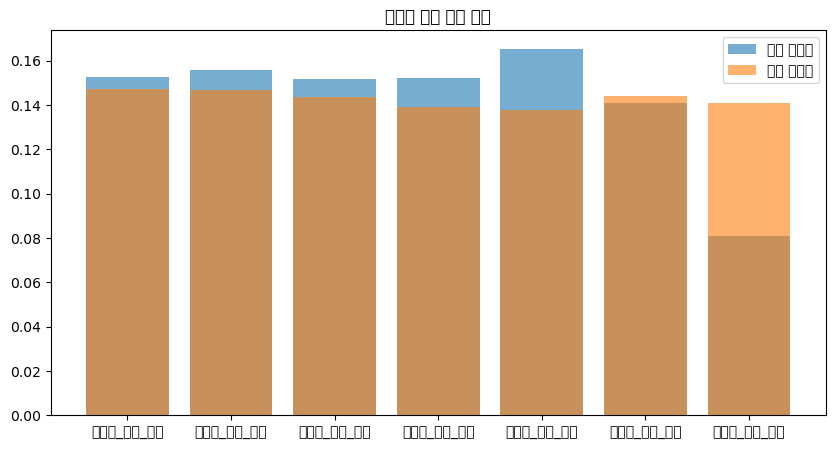

요일별 매출 비율 MSE: 0.0006747959118144538


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 파일 경로 설정
original_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"
generated_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\일단위_매출_추정치.csv"

# 데이터 로드
original_df = pd.read_csv(original_file)
generated_df = pd.read_csv(generated_file)

# 원본 데이터 요일별 매출 비율 계산
original_sales = original_df[['월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액',
                               '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액']].sum()
original_ratio = original_sales / original_sales.sum()

# 요일 매핑
day_mapping = {
    "Monday": "월요일_매출_금액",
    "Tuesday": "화요일_매출_금액",
    "Wednesday": "수요일_매출_금액",
    "Thursday": "목요일_매출_금액",
    "Friday": "금요일_매출_금액",
    "Saturday": "토요일_매출_금액",
    "Sunday": "일요일_매출_금액"
}

# 요일 매핑 적용
generated_df['요일'] = generated_df['요일'].map(day_mapping)

# 요일별 매출 합 계산
generated_ratio = generated_df.groupby('요일')['매출'].sum()
generated_ratio /= generated_ratio.sum()

# 비율 비교 시각화
plt.figure(figsize=(10, 5))
plt.bar(original_ratio.index, original_ratio.values, alpha=0.6, label='원본 데이터')
plt.bar(generated_ratio.index, generated_ratio.values, alpha=0.6, label='생성 데이터')
plt.title("요일별 매출 비율 비교")
plt.legend()
plt.show()

# MSE 계산
common_days = list(set(original_ratio.index) & set(generated_ratio.index))
mse = mean_squared_error(original_ratio.loc[common_days].values, generated_ratio.loc[common_days].values)
print(f"요일별 매출 비율 MSE: {mse}")

검증결과

📊 평가:
평균 오차 비율: -0.0067% → 전반적으로 원본 데이터와 거의 일치하는 수준임.
중앙값 오차 비율: 0.0000% → 대부분의 상권에서는 큰 차이가 없음.
표준편차: 0.5703% → 오차가 전체적으로 안정적인 편.
오차 5% 이상인 데이터 개수: 10개 / 33,021개 → 약 0.03% 수준이므로 무시해도 될 정도.

📈 주목해야 할 점:
일부 최대 오차(35.25%) 및 최소 오차(-7.69%) 발생한 경우가 있음.
특히, 광진경찰서(35.25%), 개미어린이공원(28.26%), 신림역 1번(31.26%) 등의 오차율이 높은 경우는 원인 분석이 필요.
오차가 큰 데이터가 특정 지역에 집중되어 있다면, 특정 상권의 데이터 처리 과정에서 문제가 발생했을 가능성이 있음.

✅ 결론:
전체적으로 양호한 수준으로 보임.
다만, 오차가 큰 일부 상권(오차율 10% 이상)은 검토하는 것이 좋음.
→ 원본 데이터와 비교하여 전처리 과정에서 손실이 발생했는지 확인해보는 것이 필요.
그래도 전체 데이터의 99.97% 이상이 매우 작은 오차 범위 내에 있으므로 실무적으로 큰 문제는 아님.

계산 방식 개선 코드(단순히 분기를 13으로 나누는 것이 아니라 분기별 실제 날짜수와 요일수를 확인하고 이를 반영하여 계산, 상권만 고려하는 것이 아니라 업종까지 고려하여 학습, 계산)

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np

# 파일 경로 설정
file_path = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\피처엔지니어링일단다한통합데이터.csv"

# 데이터 로드
df = pd.read_csv(file_path)

# 필요한 칼럼 선택
df = df[['기준_년분기_코드', '상권_코드_명', '서비스_업종_코드_명', 
          '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', 
          '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액']]

# 기준_년분기_코드를 날짜로 변환 (각 분기의 첫 번째 날)
def convert_quarter_to_date(quarter_code):
    year = int(str(quarter_code)[:4])
    quarter = int(str(quarter_code)[4:])
    month = {1: '01', 2: '04', 3: '07', 4: '10'}[quarter]
    return f"{year}-{month}-01"

df['날짜'] = df['기준_년분기_코드'].apply(convert_quarter_to_date)
df['날짜'] = pd.to_datetime(df['날짜'])

# 분기별 실제 날짜 수 계산
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2024-06-30")

# 전체 날짜 범위 데이터프레임 생성
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
date_info_df = pd.DataFrame({'날짜': date_range})
date_info_df['요일'] = date_info_df['날짜'].dt.strftime('%A')

# 원본 데이터와 날짜 범위 데이터프레임 병합
daily_sales_list = []

for _, row in df.iterrows():
    base_date = row['날짜']
    quarter_mask = (date_info_df['날짜'] >= base_date) & (date_info_df['날짜'] < base_date + pd.DateOffset(months=3))
    quarter_dates = date_info_df[quarter_mask]

    sales_values = [row['월요일_매출_금액'], row['화요일_매출_금액'], row['수요일_매출_금액'],
                     row['목요일_매출_금액'], row['금요일_매출_금액'], row['토요일_매출_금액'], row['일요일_매출_금액']]

    # 요일별 매출 매핑
    weekday_sales_map = dict(zip(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], sales_values))

    for date in quarter_dates['날짜']:
        weekday = date.strftime('%A')
        sales_value = weekday_sales_map[weekday] / quarter_dates['요일'].value_counts()[weekday]
        daily_sales_list.append({
            '날짜': date,
            '요일': weekday,
            '상권명': row['상권_코드_명'],
            '업종': row['서비스_업종_코드_명'],
            '매출': sales_value
        })

# 데이터프레임 변환
daily_sales_df = pd.DataFrame(daily_sales_list)

# Prophet 모델링 및 결과 예측
prophet_results = []

for (district, industry), group in daily_sales_df.groupby(['상권명', '업종']):
    prophet_df = group[['날짜', '매출']].rename(columns={'날짜': 'ds', '매출': 'y'})
    model = Prophet()
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=90)  # 향후 90일 예측
    forecast = model.predict(future)

    forecast = forecast[['ds', 'yhat']].rename(columns={'ds': '날짜', 'yhat': '예측_매출'})
    forecast['상권명'] = district
    forecast['업종'] = industry
    prophet_results.append(forecast)

# 예측 결과 데이터프레임으로 변환
forecast_df = pd.concat(prophet_results)

# 결과 저장
output_file = r"C:\Users\m\Desktop\머신러닝 사용 데이터\피처엔지니어링한통합데이터\Prophet_예측_결과.csv"
forecast_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print("Prophet 모델링 및 데이터 저장이 완료되었습니다.")

#rhwkfkdl

KeyboardInterrupt: 